In [1]:
#---------------------------------------#
# author : https://github.com/vidit1999 #
#---------------------------------------#

In [2]:
import gc
import random
import joblib
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core import pylabtools
from sklearn import set_config

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

from imblearn.ensemble import RUSBoostClassifier
from sklearn.ensemble import RandomForestClassifier

set_config(display='diagram')
pylabtools.figsize(16, 8)
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

In [3]:
random.seed(0)
np.random.seed(0)

In [4]:
# Data Dictionary:
# step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
# type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
# amount - amount of the transaction in local currency.
# nameOrig - customer who started the transaction
# oldbalanceOrg - initial balance before the transaction
# newbalanceOrig - new balance after the transaction
# nameDest - customer who is the recipient of the transaction
# oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
# newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
# isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
# isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [5]:
DEVELOPMENT = False

In [6]:
df = pd.read_csv(
    filepath_or_buffer="../Data/fraudulent-transactions-data.zip",
    nrows=10000 if DEVELOPMENT else 100000,
    usecols=['amount', 'isFraud', 'oldbalanceDest', 'oldbalanceOrg', 'type']
)
df

,type,amount,oldbalanceOrg,oldbalanceDest,isFraud
0,PAYMENT,9839.64,170136.0,0.00,0
1,PAYMENT,1864.28,21249.0,0.00,0
2,TRANSFER,181.00,181.0,0.00,1
3,CASH_OUT,181.00,181.0,21182.00,1
4,PAYMENT,11668.14,41554.0,0.00,0
...,...,...,...,...,...
99995,PAYMENT,4020.66,159929.0,0.00,0
99996,PAYMENT,18345.49,6206.0,0.00,0
99997,CASH_IN,183774.91,39173.0,54925.05,0
99998,CASH_OUT,82237.17,6031.0,592635.66,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   type            100000 non-null  object 
 1   amount          100000 non-null  float64
 2   oldbalanceOrg   100000 non-null  float64
 3   oldbalanceDest  100000 non-null  float64
 4   isFraud         100000 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 3.8+ MB


In [8]:
df.isnull().sum()

type              0
amount            0
oldbalanceOrg     0
oldbalanceDest    0
isFraud           0
dtype: int64

In [9]:
df.describe(percentiles=np.linspace(0.1, 0.9, 9))

,amount,oldbalanceOrg,oldbalanceDest,isFraud
count,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000
mean,1.736022e+05,8.777575e+05,8.805048e+05,0.001160
std,3.443003e+05,2.673284e+06,2.402267e+06,0.034039
min,3.200000e-01,0.000000e+00,0.000000e+00,0.000000
10%,3.528780e+03,0.000000e+00,0.000000e+00,0.000000
20%,7.574786e+03,0.000000e+00,0.000000e+00,0.000000
30%,1.289718e+04,0.000000e+00,0.000000e+00,0.000000
40%,2.247551e+04,5.818300e+03,0.000000e+00,0.000000
50%,5.274552e+04,2.006150e+04,2.083943e+04,0.000000
60%,1.091415e+05,4.232840e+04,1.592846e+05,0.000000


In [10]:
df['isFraud'].value_counts()

0    99884
1      116
Name: isFraud, dtype: int64

In [11]:
df.skew()

amount             5.428317
oldbalanceOrg      4.957886
oldbalanceDest     5.057145
isFraud           29.310338
dtype: float64

In [12]:
df.kurtosis()

amount             48.099033
oldbalanceOrg      31.578943
oldbalanceDest     32.478671
isFraud           857.113042
dtype: float64

In [13]:
df = pd.get_dummies(df)

<AxesSubplot:>

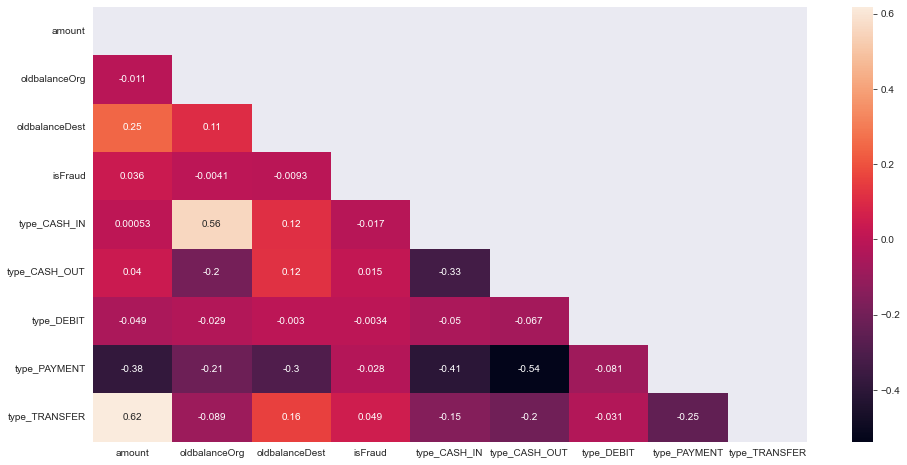

In [14]:
corr = df.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, annot=True)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='isFraud'), df['isFraud'])
X_train.shape, X_test.shape

((75000, 8), (25000, 8))

In [16]:
X_train.columns

Index(['amount', 'oldbalanceOrg', 'oldbalanceDest', 'type_CASH_IN',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')

In [17]:
pipeline = Pipeline([
    # apply transformations
    ("col_trans", ColumnTransformer(
        transformers=[
            # robust scaler
            ("robust_scaler", RobustScaler(), ['amount', 'oldbalanceOrg', 'oldbalanceDest'])
        ],
        remainder='passthrough'
    )),
    
    # model
    ("model",
     RUSBoostClassifier(
         base_estimator=RandomForestClassifier(n_jobs=-1),
         random_state=0
     )
    )
])
pipeline

Pipeline(steps=[('col_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robust_scaler',
                                                  RobustScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'oldbalanceDest'])])),
                ('model',
                 RUSBoostClassifier(base_estimator=RandomForestClassifier(n_jobs=-1),
                                    random_state=0))])

In [18]:
y_pred = pipeline.fit(X_train, y_train).predict(X_test)

In [19]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.96      0.81      0.98      0.88      0.79     24974
          1       0.02      0.81      0.96      0.04      0.88      0.77        26

avg / total       1.00      0.96      0.81      0.98      0.88      0.79     25000



<AxesSubplot:>

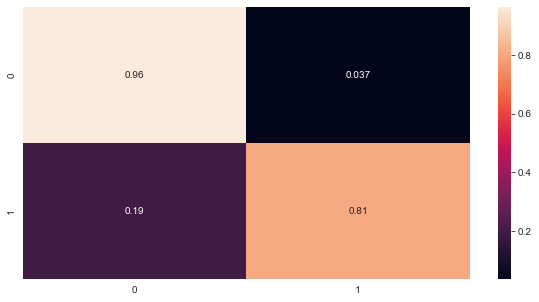

In [20]:
plt.figure(figsize=(10, 5))

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)

In [21]:
joblib.dump(pipeline, "../Data/fraudulent-transactions-pred.pkl")

['../Data/fraudulent-transactions-pred.pkl']